# Minimum Feedback Vertex Set on Directed Graphs

This notebook contains an annotated implementation of several algorithms for the **Minimum Feedback Vertex Set (MFVS)** problem on directed graphs.

**Algorithms included:**
1. Naive Exact FVS
2. Greedy Frequency
3. Greedy Degree‑Product
4. Wang–Lloyd–Soffa
5. Small‑k Iterative Compression
6. Variable Neighborhood Search (VNS) Heuristic

**Notes:**
* The notebook contains function that loads a directed graph from a delimited edge-list file and returns it as a NetworkX DiGraph, and function that generates random directed graphs of varying sizes and densities, visualizes them, and applies several heuristics and exact methods to analyze or approximate solutions for each graph.

## Imports & Directed Utilities

In [1]:
import itertools, time, csv, random
from typing import List, Set, Dict, Iterable, Tuple
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
from __future__ import annotations

def is_acyclic(G: nx.DiGraph) -> bool:
    """Return True if G is a DAG (no directed cycles)."""
    if not G.is_directed():
        raise TypeError('Expected nx.DiGraph for DFVS utilities.')
    return nx.is_directed_acyclic_graph(G)

def is_acyclic_after_removing(G: nx.DiGraph, S: Iterable[int]) -> bool:
    H = G.copy()
    H.remove_nodes_from(S)
    return nx.is_directed_acyclic_graph(H)

def cycle_basis(G: nx.DiGraph) -> List[List]:
    """Directed analog: list of simple directed cycles (may be many)."""
    if not G.is_directed():
        raise TypeError('Expected nx.DiGraph for DFVS utilities.')
    return list(nx.simple_cycles(G))

def clean_graph(G: nx.DiGraph) -> nx.DiGraph:
    """Iteratively remove sources (in=0) and sinks (out=0)."""
    if not G.is_directed():
        raise TypeError('Expected nx.DiGraph for DFVS utilities.')
    H = G.copy()
    changed = True
    while changed:
        changed = False
        for v in list(H.nodes()):
            if H.in_degree(v) == 0 or H.out_degree(v) == 0:
                H.remove_node(v)
                changed = True
    return H

def validate_dfvs(G: nx.DiGraph, F: Iterable) -> bool:
    H = G.copy()
    H.remove_nodes_from(list(F))
    return nx.is_directed_acyclic_graph(H)

# Visualization helpers
def draw_digraph(G: nx.DiGraph, title: str=''):
    pos = nx.spring_layout(G, seed=7)
    nx.draw(G, pos, with_labels=True, arrows=True)
    plt.title(title)
    plt.show()

def highlight_dfvs(G: nx.DiGraph, F: Set, title: str=''):
    pos = nx.spring_layout(G, seed=7)
    colors = ['C3' if v in F else 'C0' for v in G.nodes()]
    nx.draw(G, pos, with_labels=True, arrows=True, node_color=colors)
    plt.title(title)
    plt.show()

def visualize_solution(G: nx.DiGraph, F: Set, label: str, runtime: float):
    fig, ax = plt.subplots(figsize=(6, 6))
    pos = nx.spring_layout(G, seed=42)

    nx.draw(G, pos, with_labels=True, node_size=500, edge_color="gray", alpha=0.7, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=F, node_color="red", ax=ax)

    title = f"{label} | |F|={len(F)}"
    if runtime is not None:
        title += f" | time={runtime:.3f}s"
    ax.set_title(title)

    return fig   

    


## Naive Exact FVS (small graphs only)

In [2]:
def naive_dfvs(G: nx.DiGraph, time_limit: float | None = None) -> Set:
    """Exhaustive search over vertex subsets; only for tiny graphs."""
    start = time.time()
    if is_acyclic(G):
        return set()
    V = list(G.nodes())
    best = set(V)
    for r in range(1, len(V)+1):
        for S in itertools.combinations(V, r):
            if time_limit is not None and time.time() - start > time_limit:
                return set(best)
            H = G.copy(); H.remove_nodes_from(S)
            if is_acyclic(H):
                return set(S)
    return best

# Visualization block for Naive 
def run_naive_and_plot(G: nx.DiGraph,  instance_name: str,  time_limit: float = 3.0):
    t0 = time.time()
    F = naive_dfvs(G, time_limit=time_limit)
    t1 = time.time()
    fig = visualize_solution(G, F, label="naive_small", runtime=t1 - t0)
    fig.savefig(f"{instance_name}_naive_small.png", dpi=300, bbox_inches='tight')
    plt.close(fig)


## Greedy Frequency (cycle participation)

In [3]:
def greedy_frequency_dfvs(G: nx.DiGraph, cap: int | None = 10000) -> Set:
    """Remove the vertex appearing most often across simple directed cycles (capped)."""
    H = clean_graph(G)
    F = set()
    while not is_acyclic(H):
        occ: Dict = {}; cnt = 0
        for cyc in nx.simple_cycles(H):
            for v in cyc:
                occ[v] = occ.get(v, 0) + 1
            cnt += 1
            if cap is not None and cnt >= cap:
                break
        if not occ:
            break
        v_star = max(occ.items(), key=lambda kv: kv[1])[0]
        H.remove_node(v_star)
        F.add(v_star)
        H = clean_graph(H)
    return F

# Visualization block for frequency 
def run_frequency_and_plot(G: nx.DiGraph,  instance_name: str, cap: int = 10000):
    t0 = time.time()
    F = greedy_frequency_dfvs(G, cap=cap)
    t1 = time.time()
    
    fig = visualize_solution(G, F, label="frequency", runtime=t1 - t0)
    fig.savefig(f"{instance_name}_frequency.png", dpi=300, bbox_inches='tight')
    plt.close(fig)


## Greedy Degree‑Product (in_degree * out_degree)

In [4]:
def greedy_degree_product(G: nx.DiGraph, time_limit: float = 5.0) -> Set:
    """Greedy: pick node maximizing in_degree*out_degree, with pruning."""
    start = time.time()
    H = clean_graph(G)
    F = set()
    while not is_acyclic(H):
        if time.time() - start > time_limit:
            break
        best_v, best_s = None, -1
        for v in H.nodes():
            s = H.in_degree(v) * H.out_degree(v)
            if s > best_s:
                best_s, best_v = s, v
        if best_v is None:
            break
        F.add(best_v)
        H.remove_node(best_v)
        H = clean_graph(H)
    return F

# Visualization block for Degree‑Product ---
def run_degprod_and_plot(G: nx.DiGraph, instance_name: str, time_limit: float = 5.0, ):
    t0 = time.time()
    F = greedy_degree_product(G, time_limit=time_limit)
    t1 = time.time()
    fig = visualize_solution(G, F, label="degprod", runtime=t1 - t0)
    fig.savefig(f"{instance_name}_degprod.png", dpi=300, bbox_inches='tight')
    plt.close(fig)



## Wang–Lloyd–Soffa: Associated Graph and D‑Sequence

In [5]:
def _deadlocked_nodes(G: nx.DiGraph) -> Set:
    """Nodes that can reach some directed cycle (via any path)."""
    cyc_nodes = set()
    for cyc in nx.simple_cycles(G):
        for u in cyc:
            cyc_nodes.add(u)
    if not cyc_nodes:
        return set()
    Gr = G.reverse(copy=False)
    seen = set()
    stack = list(cyc_nodes)
    while stack:
        s = stack.pop()
        if s in seen: 
            continue
        seen.add(s)
        for nbr in Gr.successors(s):
            if nbr not in seen:
                stack.append(nbr)
    return seen

def associated_graph(G: nx.DiGraph, x) -> nx.DiGraph:
    if not G.has_node(x):
        return nx.DiGraph()
    H = G.copy()
    H.remove_node(x)
    dead = _deadlocked_nodes(H)
    keep = {x} | (set(G.nodes()) - dead)
    return G.subgraph(keep).copy()

def d_sequence_reduce(G: nx.DiGraph) -> Tuple[List, Set]:
    """Attempt WLS D‑sequence reduction; returns (sequence, F_candidate)."""
    seq, F = [], set(); H = G.copy()
    while not is_acyclic(H):
        chosen = None
        for x in H.nodes():
            A = associated_graph(H, x)
            if not is_acyclic(A):
                chosen = x; break
        if chosen is None:
            return seq, F
        seq.append(chosen)
        F.add(chosen)
        H.remove_nodes_from(list(associated_graph(H, chosen).nodes()))
    return seq, F

# Visualization block for D‑sequence 
def run_dseq_and_plot(G: nx.DiGraph, instance_name: str):
    t0 = time.time()
    seq, F = d_sequence_reduce(G)
    t1 = time.time()
    fig = visualize_solution(G, F, label="dseq", runtime=t1 - t0)
    fig.savefig(f"{instance_name}_dseq.png", dpi=300, bbox_inches='tight')
    plt.close(fig)


## Small‑k Iterative Compression (sketch)

In [6]:
def ic_dfvs_small_k(G: nx.DiGraph, k: int) -> Tuple[bool, Set]:
    """Tiny IC scaffold; exact only for very small k/instances."""
    if k > 20:
        raise ValueError('k too big')
    nodes = list(G.nodes())
    if not nodes: return True, set()
    H = nx.DiGraph()
    H.add_node(nodes[0])
    F = set()
    for i in range(1, len(nodes)):
        v = nodes[i]
        H.add_node(v)
        for u,w in G.edges():
            if u in H and w in H:
                H.add_edge(u,w)
        if not validate_dfvs(H, F):
            F |= dfvs_heuristic(H, mode='degree_product', time_limit=1.0)
        if len(F) <= k and validate_dfvs(H, F):
            continue
        best = None
        for r in range(len(F)+1):
            for Y in itertools.combinations(F, r):
                Y = set(Y)
                X = F - Y
                Hred = H.copy()
                Hred.remove_nodes_from(Y)
                cand = dfvs_heuristic(Hred, mode='degree_product', time_limit=1.0)
                cand = {u for u in cand if u not in X}
                Fnew = Y | cand
                if validate_dfvs(H, Fnew):
                    if best is None or len(Fnew) < len(best):
                        best = Fnew
            if best is not None and len(best) <= k:
                F = best
                break
        if best is None:
            return False, set()
    return True, F

# Visualization block for Small-k Iterative Compression
def run_ic_small_and_plot(G: nx.DiGraph, instance_name: str, k: int):
    t0 = time.time()
    flag, F = ic_dfvs_small_k(G, k)
    t1 = time.time()
    if flag:
        fig = visualize_solution(G, F, label="ic_small_k", runtime=t1 - t0)
        fig.savefig(f"{instance_name}_ic_small_k.png", dpi=300, bbox_inches='tight')
        plt.close(fig)
    else:
        print("|MFVS| <= k not found")
        

## Post‑Reduction and Unified Wrapper

In [7]:
def post_reduce(G: nx.DiGraph, F: Iterable) -> Set:
    """Try to remove redundant vertices from F (greedy backward pass)."""
    F = list(F)
    kept = set(F)
    for v in F:
        trial = kept - {v}
        if validate_dfvs(G, trial):
            kept = trial
    return kept

def dfvs_heuristic(G: nx.DiGraph, mode: str = 'degree_product', **kwargs) -> Set:
    if mode == 'degree_product':
        F = greedy_degree_product(G, time_limit=kwargs.get('time_limit', 5.0))
    elif mode == 'frequency':
        F = greedy_frequency_dfvs(G, cap=kwargs.get('cap', 10000))
    elif mode == 'naive_small':
        F = naive_dfvs(G, time_limit=kwargs.get('time_limit', 3.0))
    elif mode == 'ic_small_k':
        F = ic_dfvs_small_k(G, k=kwargs.get('k', 20))
    elif mode == 'd_sequence':
        seq, F = d_sequence_reduce(G)
        if not validate_dfvs(G, F):
            H = G.copy()
            H.remove_nodes_from(F)
            F |= greedy_degree_product(H, time_limit=kwargs.get('time_limit', 5.0))
    else:
        raise ValueError('Unknown mode')
    return post_reduce(G, F)

# Visualization block for Wrapper (choose a mode) ---
def run_wrapper_and_plot(G: nx.DiGraph, instance_name: str, mode: str = 'degree_product',  **kwargs):
    t0 = time.time()
    F = dfvs_heuristic(G, mode=mode, **kwargs)
    t1 = time.time()
    visualize_solution(G, F, label=f'wrapper[{mode}]', runtime=t1 - t0)
    plt.savefig("wrapper_output.png")


## VNS

In [8]:
def bool_from_set_labels(G: nx.DiGraph, S: Iterable) -> List[bool]:
    """Return a boolean vector aligned with list(G.nodes())."""
    nodes = list(G.nodes())
    idx = {u: i for i, u in enumerate(nodes)}
    x = [False] * len(nodes)
    for u in S:
        if u in idx:
            x[idx[u]] = True
    return x

def set_from_bool_labels(G: nx.DiGraph, x: List[bool]) -> set:
    """Return a label set from a boolean vector aligned with list(G.nodes())."""
    nodes = list(G.nodes())
    return {nodes[i] for i, b in enumerate(x) if b}

def initialize_dfvs(G: nx.DiGraph, method: str = "degree_product") -> List[bool]:
    if method == "degree_product":
        S = greedy_degree_product(G, time_limit=5.0)  # returns label set
        return bool_from_set_labels(G, S)
    # fallback random 10% removed, label-agnostic
    x = [False] * G.number_of_nodes()
    import random
    for i in random.sample(range(len(x)), k=max(1, len(x)//10)):
        x[i] = True
    return x

def calc_fitness_dfvs(solution: List[bool], G: nx.DiGraph, penalty: float | None = None) -> float:
    """
    Fitness(x) = |S|                       if G\\S is acyclic
                 |S| + penalty (default n) else
    """
    n = G.number_of_nodes()
    S = set_from_bool_labels(G, solution)
    P = float(n) if penalty is None else float(penalty)
    if is_acyclic_after_removing(G, S):
        return float(len(S))
    return float(len(S)) + P

def local_search_remove_first_improvement(
    solution: List[bool],
    current_fitness: float,
    G: nx.DiGraph,
    penalty: float | None = None
) -> float:
    """
    Try to turn off each True (single pass, first-improvement).
    Modifies solution in-place if an equal/better fitness is found.
    """
    base_true_idx = [i for i, b in enumerate(solution) if b]
    for v in base_true_idx:
        if solution[v] is False:
            continue
        solution[v] = False
        new_fit = calc_fitness_dfvs(solution, G, penalty=penalty)
        if new_fit <= current_fitness:
            return new_fit
        solution[v] = True
    return current_fitness


from copy import deepcopy
import random

def shaking(solution: List[bool], k: int) -> List[bool]:
    """Return a random neighbor from k-th neighborhood (k bit flips)."""
    assert len(solution) >= k, f"cannot flip more than {len(solution)} bits"
    indices = random.sample(range(len(solution)), k)
    new_solution = deepcopy(solution)
    for i in indices:
        new_solution[i] = not new_solution[i]
    return new_solution


def vns_dfvs(
    G: nx.DiGraph,
    num_iters: int = 40,
    local_search: Callable[[List[bool], float, nx.DiGraph, float | None], float] = None,
    neighborhoods: Iterable[int] = range(1, 4),
    move_prob: float = 0.3,
    penalty: float | None = None,
    init_method: str = "degree_product",
    rng_seed: int | None = None,
) -> Tuple[List[bool], float, list[float]]:
    """
    Variable Neighborhood Search for DFVS.
    Returns (best_solution_bool_vector, best_fitness, fitness_history).
    """
    if rng_seed is not None:
        random.seed(rng_seed)

    if local_search is None:
        local_search = local_search_remove_first_improvement

    best_sol = initialize_dfvs(G, method=init_method)
    best_fit = calc_fitness_dfvs(best_sol, G, penalty=penalty)
    hist = [best_fit]

    for _ in range(num_iters):
        improved = False
        for k in neighborhoods:
            cand = shaking(best_sol, k)
            cand_fit = calc_fitness_dfvs(cand, G, penalty=penalty)
            cand_fit = local_search(cand, cand_fit, G, penalty=penalty)

            if (cand_fit < best_fit) or (cand_fit == best_fit and random.random() < move_prob):
                best_sol = deepcopy(cand)
                best_fit = cand_fit
                hist.append(best_fit)
                improved = True
                break
        if not improved:
            hist.append(best_fit)

    # Validate DFVS (G \ S must be a DAG)
    if not is_acyclic_after_removing(G, set_from_bool_labels(G, best_sol)):
        print("VNS did not return a valid DFVS (the graph after removal is not a DAG).")

    return best_sol, best_fit, hist


def run_vns_and_plot(
    G: nx.DiGraph,
    instance_name: str,
    num_iters: int = 40,
    neighborhoods=range(1, 4),
    move_prob: float = 0.3,
    penalty: float | None = None,
    init_method: str = "degree_product",
    local_search=local_search_remove_first_improvement,
    rng_seed: int | None = None,
    show_curve: bool = True,
):
    t0 = time.time()
    sol_bool, fit, hist = vns_dfvs(
        G=G,
        num_iters=num_iters,
        local_search=local_search,
        neighborhoods=neighborhoods,
        move_prob=move_prob,
        penalty=penalty,
        init_method=init_method,
        rng_seed=rng_seed,
    )
    t1 = time.time()

    F = set_from_bool_labels(G, sol_bool)

    fig = visualize_solution(G, F, label="vns", runtime=t1 - t0)
    fig.savefig(f"{instance_name}_vns.png", dpi=300, bbox_inches='tight')
    plt.close(fig)

    print("Best fitness:", fit)
    print("Best solution set:", F)

    if show_curve:
        fig2, ax = plt.subplots()
        ax.plot(hist)
        ax.set_xlabel("Evaluation index")
        ax.set_ylabel("Fitness")
        ax.set_title("VNS DFVS — Fitness history")

        fig2.savefig(f"{instance_name}_vns_curve.png", dpi=300, bbox_inches='tight')
        plt.close(fig2)



## I/O Helpers (CSV/TXT Edgelists)

In [9]:
def load_digraph_from_edgelist(path: str, delimiter: str = ',', header: bool = False) -> nx.DiGraph:
    G = nx.DiGraph()
    with open(path, 'r', encoding='utf-8') as f:
        first = True
        for line in f:
            if header and first:
                first = False; continue
            line = line.strip()
            if not line: continue
            parts = line.split(delimiter)
            if len(parts) < 2: continue
            u, v = parts[0].strip(), parts[1].strip()
            G.add_edge(u, v)
    return G


## Demo & Per‑Heuristic Visualization on a Small DiGraph

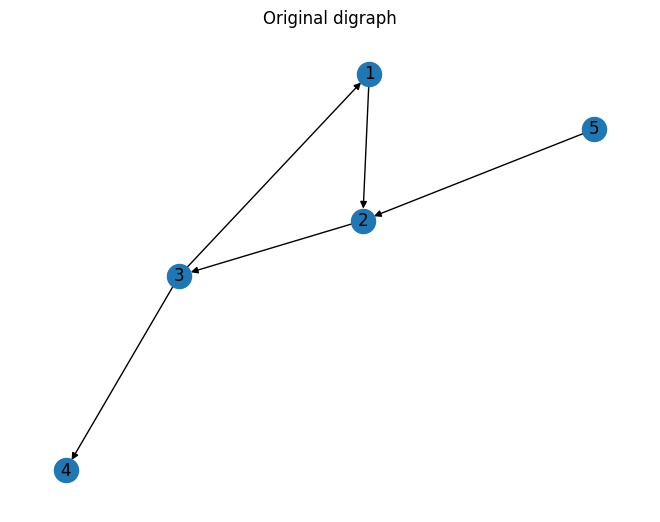

Best fitness: 1.0
Best solution set: {3}


In [10]:
# Demo instance
G_demo = nx.DiGraph(); G_demo.add_edges_from([(1,2),(2,3),(3,1),(3,4),(5,2)])
draw_digraph(G_demo, 'Original digraph')

# Show each heuristic directly below its section:
run_degprod_and_plot(G_demo,  instance_name= 'G_demo', time_limit=2.0)
run_frequency_and_plot(G_demo, instance_name='G_demo', cap=200)
run_naive_and_plot(G_demo, instance_name='G_demo', time_limit=2.0,)
run_dseq_and_plot(G_demo, instance_name ='G_demo')
run_ic_small_and_plot(G_demo, instance_name='G_demo', k = 20,)
run_vns_and_plot(
    G_demo,
    instance_name = 'G_demo',
    num_iters=30,   # number of iterations
    neighborhoods=range(1, 4),
    move_prob=0.3,
    penalty=None,
    init_method="degree_product",
    local_search=local_search_remove_first_improvement,
    rng_seed=42,
    show_curve=True
)

## Random Directed Graph Generation and Heuristic Analysis

Instance: Graph_15_nodes_p0.15


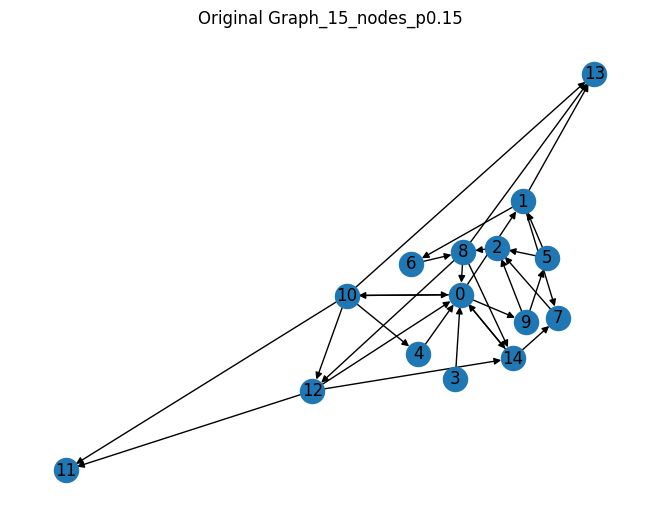

Naive exact skipped: graph too large
Best fitness: 2.0
Best solution set: {0, 14}
Instance: Graph_20_nodes_p0.10


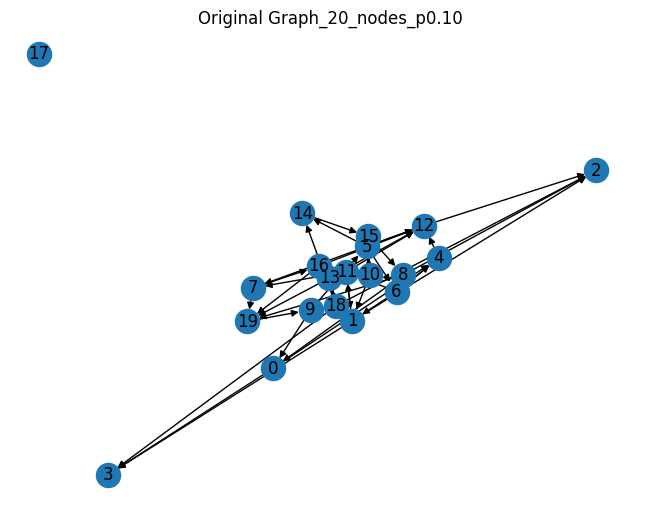

Naive exact skipped: graph too large
Best fitness: 5.0
Best solution set: {4, 5, 11, 13, 16}
Instance: Graph_30_nodes_p0.08


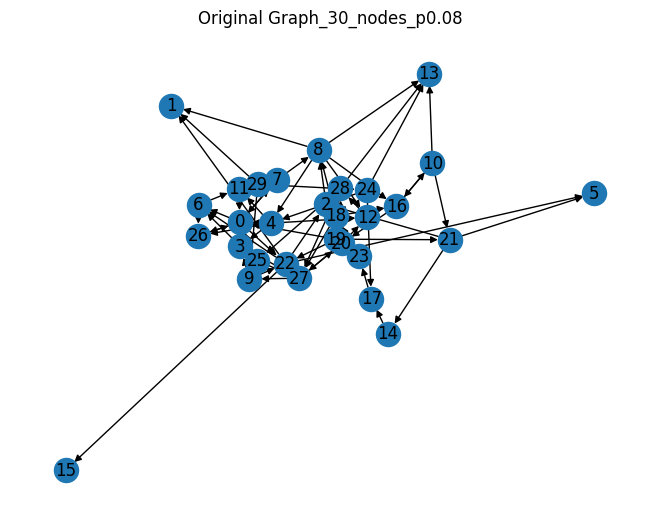

Naive exact skipped: graph too large
Best fitness: 5.0
Best solution set: {0, 8, 10, 16, 27}
Instance: Graph_40_nodes_p0.20


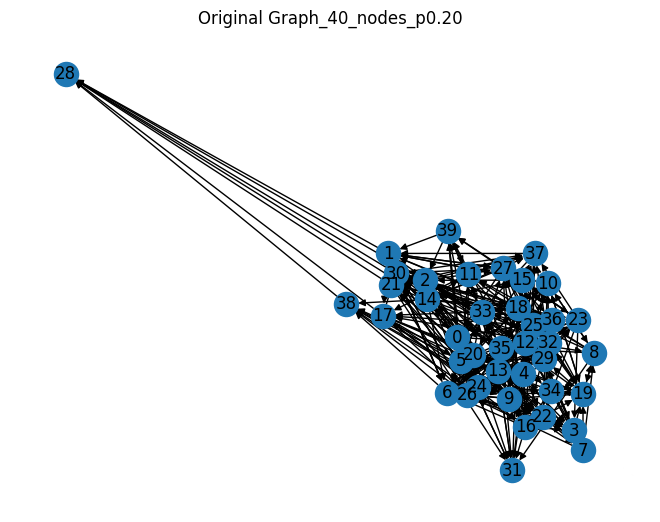

Naive exact skipped: graph too large


In [ ]:
def random_digraph(n: int, p: float, seed: int = 0) -> nx.DiGraph:
    import random
    rnd = random.Random(seed)
    G = nx.DiGraph(); G.add_nodes_from(range(n))
    for u in range(n):
        for v in range(n):
            if u != v and rnd.random() < p:
                G.add_edge(u, v)
    return G

# Test instances: larger, denser digraphs
instances = [
    ("Graph_15_nodes_p0.15", random_digraph(15, 0.15, seed=1)),
    ("Graph_20_nodes_p0.10", random_digraph(20, 0.10, seed=2)),
    ("Graph_30_nodes_p0.08", random_digraph(30, 0.08, seed=3)),
    ("Graph_40_nodes_p0.20", random_digraph(40, 0.20, seed=4)),
    ("Graph_50_nodes_p0.25", random_digraph(50, 0.25, seed=5)),
    ("Graph_60_nodes_p0.17", random_digraph(60, 0.17, seed=6)),
    ("Graph_70_nodes_p0.13", random_digraph(70, 0.13, seed=7)),
    ("Graph_80_nodes_p0.34", random_digraph(80, 0.34, seed=8)),
    ("Graph_90_nodes_p0.46", random_digraph(90, 0.46, seed=9)),
    ("Graph_100_nodes_p0.57", random_digraph(100, 0.57, seed=10)),
    ("Graph_110_nodes_p0.12", random_digraph(110, 0.12, seed=11)),
    ("Graph_120_nodes_p0.15", random_digraph(120, 0.15, seed=12))
]

for name, G in instances:
    print("="*60)
    print("Instance:", name)
    draw_digraph(G, f"Original {name}")
    
    # Degree-product heuristic
    run_degprod_and_plot(G, instance_name =name, time_limit=3.0)
    
    # Frequency heuristic
    run_frequency_and_plot(G, instance_name =name, cap=2000)
    
    # Naive exact (only feasible for very small n, so skip if too big)
    if G.number_of_nodes() <= 12:
        run_naive_and_plot(G,instance_name =name, time_limit=3.0)
    else:
        print("Naive exact skipped: graph too large")
    
    # D-sequence heuristic
    run_dseq_and_plot(G, instance_name =name)

    #IC Small-k heuristic
    run_ic_small_and_plot(G, instance_name =name, k = 20)
    run_vns_and_plot(
        G,
        instance_name =name,
        num_iters=40,
        neighborhoods=range(1, 4),
        move_prob=0.3,
        penalty=None,
        init_method="degree_product",
        local_search=local_search_remove_first_improvement,
        rng_seed=123,
        show_curve=True
    )
    

In [11]:
# Loading graphs from literature
G1 = load_digraph_from_edgelist('./data/G1_edgelist.csv')
G2 = load_digraph_from_edgelist('./data/G2_edgelist.csv')
G3 = load_digraph_from_edgelist('./data/G3_edgelist.csv')
G4 = load_digraph_from_edgelist('./data/G4_edgelist.csv')

In [12]:
print("TESTING ALGORITHMS ON G1")
run_degprod_and_plot(G1, instance_name = 'G1', time_limit=2.0)
run_frequency_and_plot(G1, instance_name = 'G1', cap=200)
run_naive_and_plot(G1, instance_name = 'G1', time_limit=2.0)
run_dseq_and_plot(G1, instance_name = 'G1',)
run_ic_small_and_plot(G1, instance_name = 'G1', k = 20)
run_vns_and_plot(
        G1,
        instance_name = 'G1',
        num_iters=40,
        neighborhoods=range(1, 4),
        move_prob=0.3,
        penalty=None,
        init_method="degree_product",
        local_search=local_search_remove_first_improvement,
        rng_seed=123,
        show_curve=True
    )

TESTING ALGORITHMS ON G1
Best fitness: 5.0
Best solution set: {'v11', 'v2', 'v8', 'v14', 'v5'}


In [14]:
print("TESTING ALGORITHMS ON G2")
run_degprod_and_plot(G2, instance_name = 'G2',time_limit=2.0)
run_frequency_and_plot(G2, instance_name = 'G2',cap=200)
run_naive_and_plot(G2, instance_name = 'G2', time_limit=2.0)
run_dseq_and_plot(G2, instance_name = 'G2',)
run_ic_small_and_plot(G2, instance_name = 'G2', k = 20)
run_vns_and_plot(
        G2,
        instance_name = 'G2',
        num_iters=40,
        neighborhoods=range(1, 4),
        move_prob=0.3,
        penalty=None,
        init_method="degree_product",
        local_search=local_search_remove_first_improvement,
        rng_seed=123,
        show_curve=True
    )

TESTING ALGORITHMS ON G2
Best fitness: 10.0
Best solution set: {'v1', 'v7', 'v12', 'v10', 'v19', 'v15', 'v26', 'v27', 'v21', 'v3'}


In [ ]:
print("TESTING ALGORITHMS ON G3")
run_degprod_and_plot(G3, instance_name = 'G3',time_limit=2.0)
run_frequency_and_plot(G3, instance_name = 'G3',cap=200)
run_naive_and_plot(G3, instance_name = 'G3', time_limit=2.0)
run_dseq_and_plot(G3, instance_name = 'G3',)
run_ic_small_and_plot(G3, instance_name = 'G3',k = 20)
run_vns_and_plot(
        G3,
        instance_name = 'G3',
        num_iters=40,
        neighborhoods=range(1, 4),
        move_prob=0.3,
        penalty=None,
        init_method="degree_product",
        local_search=local_search_remove_first_improvement,
        rng_seed=123,
        show_curve=True
    )

TESTING ALGORITHMS ON G3


In [ ]:
print("TESTING ALGORITHMS ON G4")
run_degprod_and_plot(G4, time_limit=2.0)
run_frequency_and_plot(G4, cap=200)
run_naive_and_plot(G4, time_limit=2.0)
run_dseq_and_plot(G4)
run_ic_small_and_plot(G4, k = 20)
run_vns_and_plot(
        G4,
        num_iters=40,
        neighborhoods=range(1, 4),
        move_prob=0.3,
        penalty=None,
        init_method="degree_product",
        local_search=local_search_remove_first_improvement,
        rng_seed=123,
        show_curve=True
    )